# Hyperpartisan News Detection Dataset Exploration

This notebook provides a comprehensive analysis of the SemEval-2019 Task 4 dataset for hyperpartisan news detection. The analysis includes dataset statistics, class distribution, text characteristics, feature analysis, and data quality assessment.

## Dataset Overview

The dataset consists of news articles labeled as either hyperpartisan or non-hyperpartisan. The goal is to detect extreme one-sided political bias in news articles.

**Source**: SemEval-2019 Task 4 - Hyperpartisan News Detection  
**Citation**: Kiesel et al., "SemEval-2019 Task 4: Hyperpartisan News Detection"

## 1. Setup and Configuration

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from lxml import etree
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Import project configuration
from cnn import config
from preprocess import load_cached_data, preprocess_and_cache

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Data Loading and Preprocessing

Load the preprocessed dataset from cache. If cache doesn't exist, the preprocessing pipeline will run automatically.

In [5]:

# Load preprocessed data
train_data = load_cached_data('train')
test_data = load_cached_data('test_byarticle')

print(f"\nDataset loaded successfully:")
print(f"  Training samples: {len(train_data):,}")
print(f"  Test samples: {len(test_data):,}")
print(f"  Total samples: {len(train_data) + len(test_data):,}")


Dataset loaded successfully:
  Training samples: 645
  Test samples: 628
  Total samples: 1,273


## 3. Dataset Statistics Overview

### 3.1 Class Distribution

Analyze the balance between hyperpartisan and non-hyperpartisan articles in both training and test sets.

In [6]:
def get_class_distribution(data, split_name):
    """Calculate class distribution statistics."""
    labels = [d['label'] for d in data]
    counter = Counter(labels)
    
    hyperpartisan = counter[1]
    non_hyperpartisan = counter[0]
    total = len(labels)
    
    return {
        'split': split_name,
        'hyperpartisan': hyperpartisan,
        'non_hyperpartisan': non_hyperpartisan,
        'total': total,
        'hyperpartisan_pct': (hyperpartisan / total) * 100,
        'non_hyperpartisan_pct': (non_hyperpartisan / total) * 100,
        'imbalance_ratio': max(hyperpartisan, non_hyperpartisan) / min(hyperpartisan, non_hyperpartisan)
    }

# Calculate distributions
train_dist = get_class_distribution(train_data, 'Training')
test_dist = get_class_distribution(test_data, 'Test')

# Create summary table
dist_df = pd.DataFrame([train_dist, test_dist])
print("\nClass Distribution Summary:")
print("=" * 80)
print(dist_df[['split', 'hyperpartisan', 'non_hyperpartisan', 'total', 
               'hyperpartisan_pct', 'non_hyperpartisan_pct', 'imbalance_ratio']].to_string(index=False))
print("=" * 80)


Class Distribution Summary:
   split  hyperpartisan  non_hyperpartisan  total  hyperpartisan_pct  non_hyperpartisan_pct  imbalance_ratio
Training            238                407    645          36.899225              63.100775         1.710084
    Test            314                314    628          50.000000              50.000000         1.000000


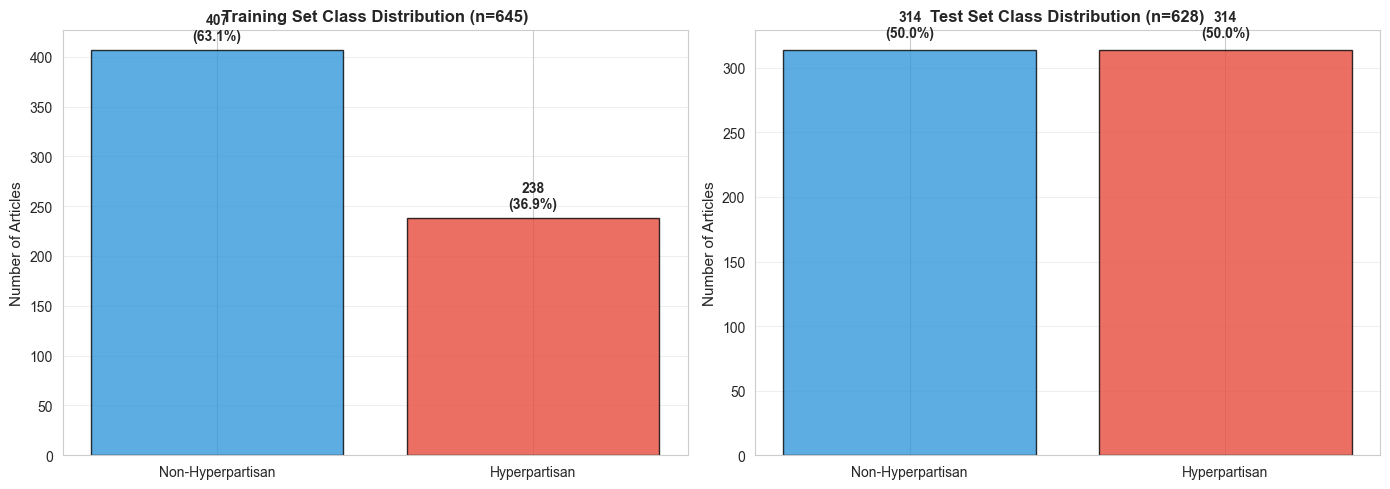


Key Observations:
  • Training set imbalance ratio: 1.71:1
  • Test set imbalance ratio: 1.00:1
  • Test set is perfectly balanced, while training set has class imbalance


In [19]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set
train_counts = [train_dist['non_hyperpartisan'], train_dist['hyperpartisan']]
colors = ['#3498db', '#e74c3c']
axes[0].bar(['Non-Hyperpartisan', 'Hyperpartisan'], train_counts, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_title(f"Training Set Class Distribution (n={train_dist['total']})", fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Articles', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_counts):
    pct = (v / train_dist['total']) * 100
    axes[0].text(i, v + 10, f"{v}\n({pct:.1f}%)", ha='center', fontweight='bold')

# Test set
test_counts = [test_dist['non_hyperpartisan'], test_dist['hyperpartisan']]
axes[1].bar(['Non-Hyperpartisan', 'Hyperpartisan'], test_counts, color=colors, alpha=0.8, edgecolor='black')
axes[1].set_title(f"Test Set Class Distribution (n={test_dist['total']})", fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Articles', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_counts):
    pct = (v / test_dist['total']) * 100
    axes[1].text(i, v + 10, f"{v}\n({pct:.1f}%)", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"  • Training set imbalance ratio: {train_dist['imbalance_ratio']:.2f}:1")
print(f"  • Test set imbalance ratio: {test_dist['imbalance_ratio']:.2f}:1")
print(f"  • Test set is perfectly balanced, while training set has class imbalance")

### 3.2 Text Length Statistics

Analyze article length distributions in terms of tokens and characters.

In [8]:
def calculate_length_statistics(data, split_name):
    """Calculate comprehensive length statistics."""
    token_lengths = [len(d['tokens']) for d in data]
    char_lengths = [len(d['text']) for d in data]
    
    percentiles = [25, 50, 75, 90, 95, 99]
    
    stats_dict = {
        'split': split_name,
        'token_min': np.min(token_lengths),
        'token_max': np.max(token_lengths),
        'token_mean': np.mean(token_lengths),
        'token_median': np.median(token_lengths),
        'token_std': np.std(token_lengths),
        'char_mean': np.mean(char_lengths),
        'char_median': np.median(char_lengths),
    }
    
    for p in percentiles:
        stats_dict[f'token_p{p}'] = np.percentile(token_lengths, p)
    
    return stats_dict, token_lengths, char_lengths

# Calculate statistics
train_stats, train_token_lens, train_char_lens = calculate_length_statistics(train_data, 'Training')
test_stats, test_token_lens, test_char_lens = calculate_length_statistics(test_data, 'Test')

# Display summary table
stats_df = pd.DataFrame([train_stats, test_stats])
print("\nText Length Statistics:")
print("=" * 100)
print(stats_df[['split', 'token_min', 'token_max', 'token_mean', 'token_median', 'token_std',
                'token_p25', 'token_p75', 'token_p95', 'token_p99']].to_string(index=False))
print("=" * 100)


Text Length Statistics:
   split  token_min  token_max  token_mean  token_median  token_std  token_p25  token_p75  token_p95  token_p99
Training         24       5649  583.604651         425.0 549.002484     247.00      752.0    1532.60    2576.36
    Test         33       5415  605.431529         483.0 505.875076     286.75      799.5    1393.45    2629.50


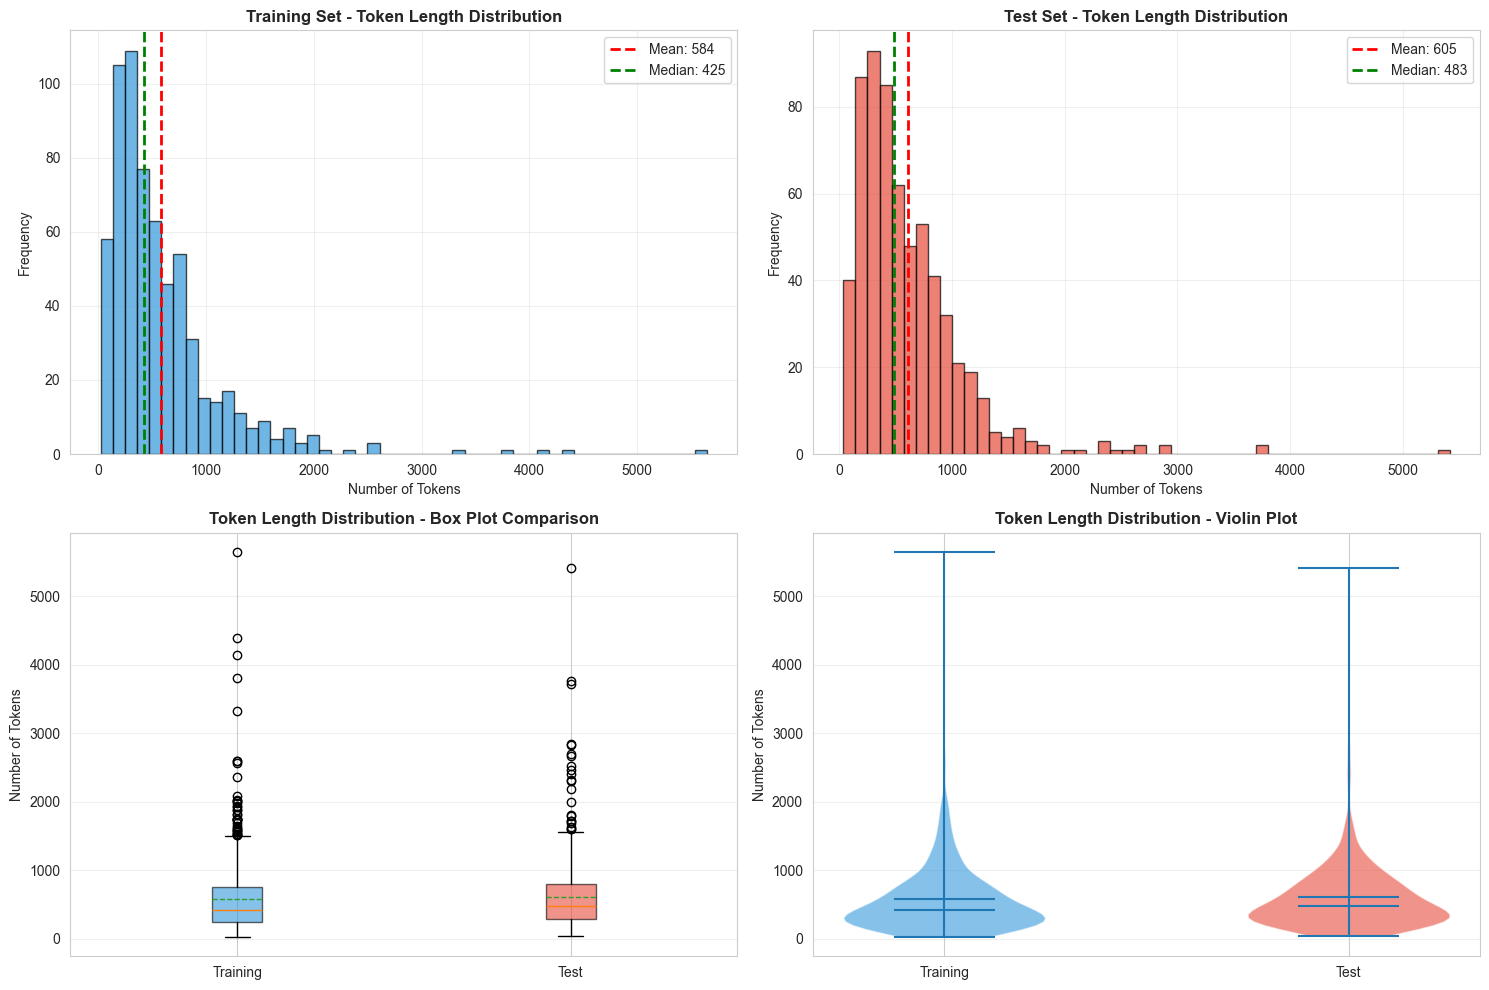

In [9]:
# Visualize token length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram - Training
axes[0, 0].hist(train_token_lens, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(train_stats['token_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {train_stats['token_mean']:.0f}")
axes[0, 0].axvline(train_stats['token_median'], color='green', linestyle='--', linewidth=2, label=f"Median: {train_stats['token_median']:.0f}")
axes[0, 0].set_title('Training Set - Token Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Tokens')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Histogram - Test
axes[0, 1].hist(test_token_lens, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(test_stats['token_mean'], color='red', linestyle='--', linewidth=2, label=f"Mean: {test_stats['token_mean']:.0f}")
axes[0, 1].axvline(test_stats['token_median'], color='green', linestyle='--', linewidth=2, label=f"Median: {test_stats['token_median']:.0f}")
axes[0, 1].set_title('Test Set - Token Length Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Tokens')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Box plot comparison
box_data = [train_token_lens, test_token_lens]
bp = axes[1, 0].boxplot(box_data, labels=['Training', 'Test'], patch_artist=True, 
                        showmeans=True, meanline=True)
for patch, color in zip(bp['boxes'], ['#3498db', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
axes[1, 0].set_title('Token Length Distribution - Box Plot Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Tokens')
axes[1, 0].grid(axis='y', alpha=0.3)

# Violin plot comparison
parts = axes[1, 1].violinplot(box_data, positions=[1, 2], showmeans=True, showmedians=True)
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(['#3498db', '#e74c3c'][i])
    pc.set_alpha(0.6)
axes[1, 1].set_xticks([1, 2])
axes[1, 1].set_xticklabels(['Training', 'Test'])
axes[1, 1].set_title('Token Length Distribution - Violin Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Number of Tokens')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Vocabulary Analysis

Examine the vocabulary size, word frequencies, and most common terms in the dataset.

In [10]:
# Collect all tokens from training set
all_tokens = []
for article in train_data:
    all_tokens.extend(article['tokens'])

# Calculate vocabulary statistics
word_freq = Counter(all_tokens)
vocab_size = len(word_freq)
total_tokens = len(all_tokens)
unique_words = len([w for w, c in word_freq.items() if c == 1])

print(f"\nVocabulary Statistics (Training Set):")
print("=" * 60)
print(f"  Total tokens: {total_tokens:,}")
print(f"  Vocabulary size (unique tokens): {vocab_size:,}")
print(f"  Hapax legomena (words appearing once): {unique_words:,} ({unique_words/vocab_size*100:.1f}%)")
print(f"  Average token frequency: {total_tokens/vocab_size:.2f}")
print(f"  Type-Token Ratio (TTR): {vocab_size/total_tokens:.4f}")
print("=" * 60)

# Top 30 most common words
print(f"\nTop 30 Most Common Words:")
print("=" * 60)
top_words = word_freq.most_common(30)
for i, (word, count) in enumerate(top_words, 1):
    pct = (count / total_tokens) * 100
    print(f"  {i:2d}. {word:15s} {count:6,} ({pct:5.2f}%)")
print("=" * 60)


Vocabulary Statistics (Training Set):
  Total tokens: 376,425
  Vocabulary size (unique tokens): 21,090
  Hapax legomena (words appearing once): 8,517 (40.4%)
  Average token frequency: 17.85
  Type-Token Ratio (TTR): 0.0560

Top 30 Most Common Words:
   1. the             20,247 ( 5.38%)
   2. to              10,720 ( 2.85%)
   3. of               8,781 ( 2.33%)
   4. and              8,360 ( 2.22%)
   5. a                7,659 ( 2.03%)
   6. in               6,516 ( 1.73%)
   7. that             5,524 ( 1.47%)
   8. s                4,700 ( 1.25%)
   9. is               4,198 ( 1.12%)
  10. for              3,152 ( 0.84%)
  11. on               2,968 ( 0.79%)
  12. it               2,959 ( 0.79%)
  13. he               2,817 ( 0.75%)
  14. was              2,690 ( 0.71%)
  15. trump            2,688 ( 0.71%)
  16. this             2,350 ( 0.62%)
  17. with             2,249 ( 0.60%)
  18. as               2,222 ( 0.59%)
  19. i                1,923 ( 0.51%)
  20. his              1,

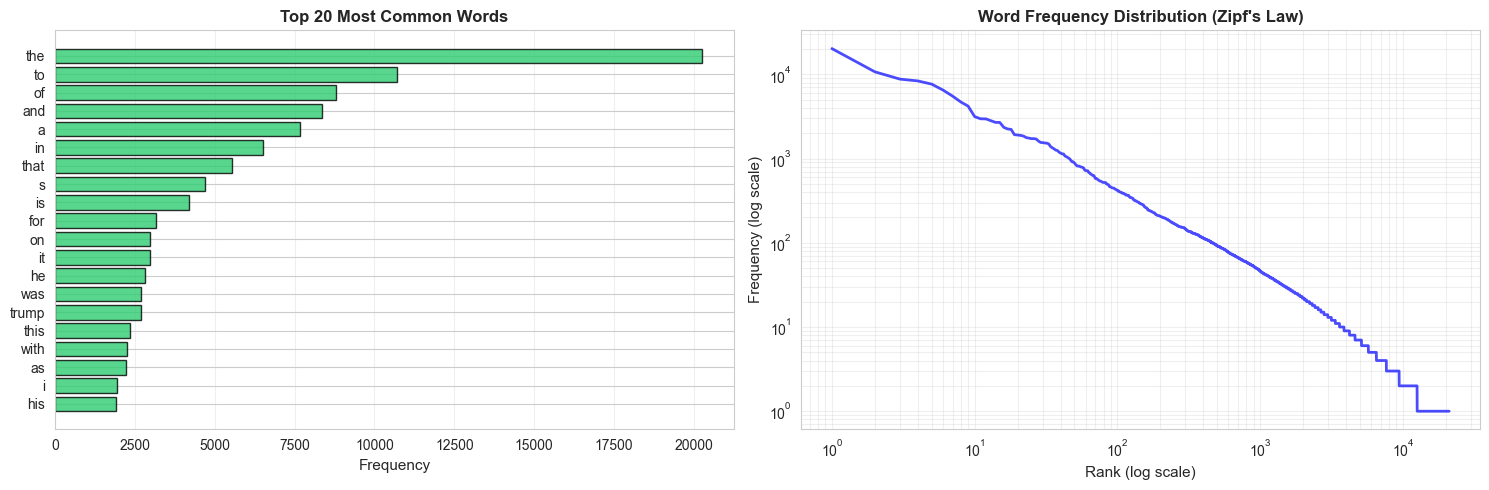

In [11]:
# Visualize word frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Top 20 words bar chart
top_20_words = word_freq.most_common(20)
words, counts = zip(*top_20_words)
axes[0].barh(range(len(words)), counts, color='#2ecc71', alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency', fontsize=11)
axes[0].set_title('Top 20 Most Common Words', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Word frequency distribution (Zipf's law)
freq_values = sorted(word_freq.values(), reverse=True)
ranks = range(1, len(freq_values) + 1)
axes[1].loglog(ranks, freq_values, 'b-', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Rank (log scale)', fontsize=11)
axes[1].set_ylabel('Frequency (log scale)', fontsize=11)
axes[1].set_title("Word Frequency Distribution (Zipf's Law)", fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

### 3.4 Comparative Analysis: Hyperpartisan vs. Non-Hyperpartisan

Compare key characteristics between the two classes to identify distinguishing patterns.

In [12]:
# Separate articles by class
hyperpartisan_articles = [d for d in train_data if d['label'] == 1]
non_hyperpartisan_articles = [d for d in train_data if d['label'] == 0]

def analyze_class(articles, class_name):
    """Analyze characteristics of a specific class."""
    token_lengths = [len(d['tokens']) for d in articles]
    hyperlink_counts = [len(d['hyperlinks']) for d in articles]
    
    return {
        'class': class_name,
        'count': len(articles),
        'avg_tokens': np.mean(token_lengths),
        'median_tokens': np.median(token_lengths),
        'std_tokens': np.std(token_lengths),
        'avg_hyperlinks': np.mean(hyperlink_counts),
        'median_hyperlinks': np.median(hyperlink_counts),
        'pct_with_links': sum(1 for c in hyperlink_counts if c > 0) / len(articles) * 100
    }

# Analyze both classes
hyper_analysis = analyze_class(hyperpartisan_articles, 'Hyperpartisan')
non_hyper_analysis = analyze_class(non_hyperpartisan_articles, 'Non-Hyperpartisan')

# Create comparison table
comparison_df = pd.DataFrame([hyper_analysis, non_hyper_analysis])
print("\nComparative Analysis:")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Statistical significance tests
hyper_tokens = [len(d['tokens']) for d in hyperpartisan_articles]
non_hyper_tokens = [len(d['tokens']) for d in non_hyperpartisan_articles]
t_stat, p_value = stats.ttest_ind(hyper_tokens, non_hyper_tokens)

print(f"\nStatistical Testing (Token Length Difference):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.6f}")
print(f"  Result: {'Statistically significant difference' if p_value < 0.05 else 'No significant difference'} (α=0.05)")


Comparative Analysis:
            class  count  avg_tokens  median_tokens  std_tokens  avg_hyperlinks  median_hyperlinks  pct_with_links
    Hyperpartisan    238  820.394958          696.5  705.733771        4.495798                2.0       70.588235
Non-Hyperpartisan    407  445.137592          337.0  366.667201        4.191646                1.0       58.476658

Statistical Testing (Token Length Difference):
  t-statistic: 8.8592
  p-value: 0.000000
  Result: Statistically significant difference (α=0.05)


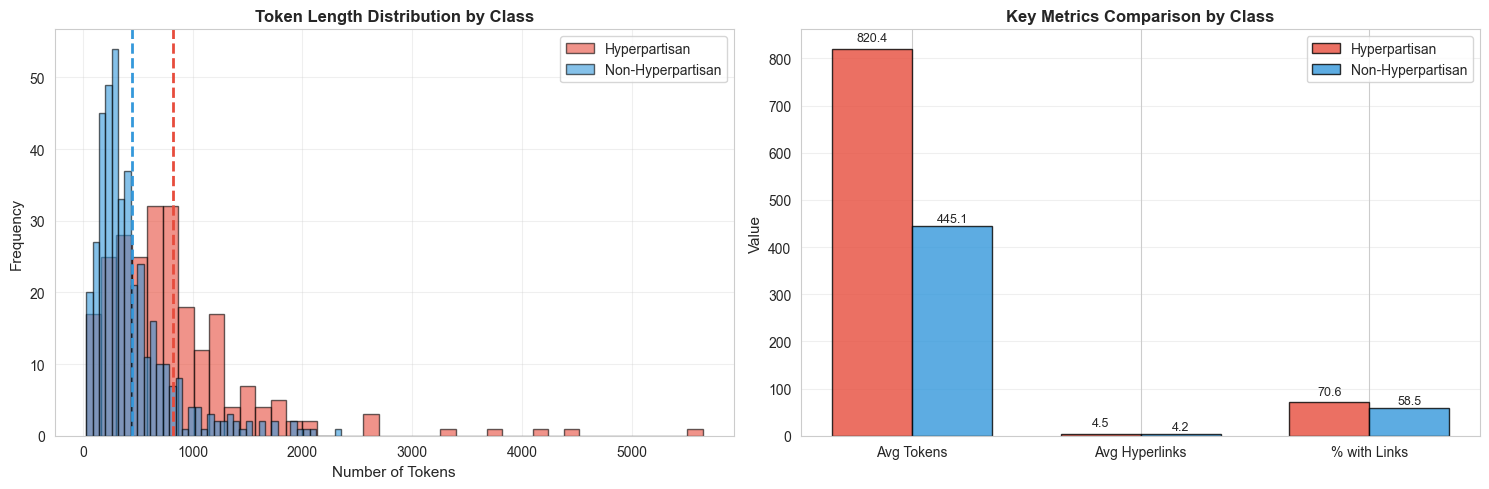

In [13]:
# Visualize class comparisons
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Token length comparison
axes[0].hist(hyper_tokens, bins=40, alpha=0.6, label='Hyperpartisan', color='#e74c3c', edgecolor='black')
axes[0].hist(non_hyper_tokens, bins=40, alpha=0.6, label='Non-Hyperpartisan', color='#3498db', edgecolor='black')
axes[0].axvline(np.mean(hyper_tokens), color='#e74c3c', linestyle='--', linewidth=2)
axes[0].axvline(np.mean(non_hyper_tokens), color='#3498db', linestyle='--', linewidth=2)
axes[0].set_xlabel('Number of Tokens', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Token Length Distribution by Class', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Hyperlink comparison
hyper_links = [len(d['hyperlinks']) for d in hyperpartisan_articles]
non_hyper_links = [len(d['hyperlinks']) for d in non_hyperpartisan_articles]

metrics = ['Avg Tokens', 'Avg Hyperlinks', '% with Links']
hyper_vals = [hyper_analysis['avg_tokens'], hyper_analysis['avg_hyperlinks'], hyper_analysis['pct_with_links']]
non_hyper_vals = [non_hyper_analysis['avg_tokens'], non_hyper_analysis['avg_hyperlinks'], non_hyper_analysis['pct_with_links']]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, hyper_vals, width, label='Hyperpartisan', color='#e74c3c', alpha=0.8, edgecolor='black')
axes[1].bar(x + width/2, non_hyper_vals, width, label='Non-Hyperpartisan', color='#3498db', alpha=0.8, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].set_ylabel('Value', fontsize=11)
axes[1].set_title('Key Metrics Comparison by Class', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

for i, (h, nh) in enumerate(zip(hyper_vals, non_hyper_vals)):
    axes[1].text(i - width/2, h + max(hyper_vals) * 0.02, f'{h:.1f}', ha='center', fontsize=9)
    axes[1].text(i + width/2, nh + max(non_hyper_vals) * 0.02, f'{nh:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

### 3.5 Feature Analysis

Analyze the extracted features including hyperlinks, sentiment scores, and named entities.

In [14]:
# Hyperlink statistics
all_hyperlinks = [len(d['hyperlinks']) for d in train_data]
articles_with_links = sum(1 for c in all_hyperlinks if c > 0)

print(f"\nHyperlink Statistics (Training Set):")
print("=" * 60)
print(f"  Total hyperlinks: {sum(all_hyperlinks):,}")
print(f"  Articles with links: {articles_with_links} ({articles_with_links/len(train_data)*100:.1f}%)")
print(f"  Articles without links: {len(train_data) - articles_with_links} ({(len(train_data) - articles_with_links)/len(train_data)*100:.1f}%)")
print(f"  Average links per article: {np.mean(all_hyperlinks):.2f}")
print(f"  Median links per article: {np.median(all_hyperlinks):.0f}")
print(f"  Max links in one article: {max(all_hyperlinks)}")
print(f"  Std deviation: {np.std(all_hyperlinks):.2f}")
print("=" * 60)

# Analyze link types
link_types = Counter()
for article in train_data:
    for link in article['hyperlinks']:
        link_types[link['type']] += 1

print(f"\nHyperlink Types:")
for link_type, count in link_types.items():
    print(f"  {link_type}: {count:,} ({count/sum(link_types.values())*100:.1f}%)")


Hyperlink Statistics (Training Set):
  Total hyperlinks: 2,776
  Articles with links: 406 (62.9%)
  Articles without links: 239 (37.1%)
  Average links per article: 4.30
  Median links per article: 1
  Max links in one article: 277
  Std deviation: 13.85

Hyperlink Types:
  external: 2,776 (100.0%)


In [15]:
# Extract extra features if they exist
if 'extra_features' in train_data[0] and len(train_data[0]['extra_features']) > 0:
    feature_matrix = np.array([d['extra_features'] for d in train_data])
    
    # Create feature names based on configuration
    feature_names = []
    if config.USE_DATE_FEATURES:
        feature_names.extend(['day_of_week', 'month'])
    if config.USE_HYPERLINK_FEATURES:
        feature_names.extend(['num_hyperlinks', 'num_external', 'num_internal', 'hyperlink_density'])
    if config.USE_SENTIMENT_FEATURES:
        feature_names.extend(['sentiment_pos', 'sentiment_neu', 'sentiment_neg'])
    if config.USE_NER_FEATURES:
        feature_names.extend(['ner_person', 'ner_org', 'ner_gpe', 'ner_loc', 'ner_other'])
    
    # Calculate correlation matrix
    if len(feature_names) > 1:
        corr_matrix = np.corrcoef(feature_matrix.T)
        
        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    xticklabels=feature_names, yticklabels=feature_names,
                    cbar_kws={'label': 'Correlation Coefficient'})
        plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # Print feature statistics
        print(f"\nExtra Features Statistics:")
        print("=" * 80)
        for i, name in enumerate(feature_names):
            values = feature_matrix[:, i]
            print(f"  {name:20s} - Mean: {np.mean(values):8.3f}, Std: {np.std(values):8.3f}, Min: {np.min(values):8.3f}, Max: {np.max(values):8.3f}")
        print("=" * 80)
else:
    print("\nNo extra features found in the dataset.")


No extra features found in the dataset.


## 4. Data Quality Assessment

### 4.1 Missing Data and Completeness

In [16]:
def assess_data_quality(data, split_name):
    """Assess data quality and completeness."""
    total = len(data)
    
    # Check for empty or missing fields
    empty_title = sum(1 for d in data if not d.get('title', '').strip())
    empty_text = sum(1 for d in data if not d.get('text', '').strip())
    empty_tokens = sum(1 for d in data if len(d.get('tokens', [])) == 0)
    missing_id = sum(1 for d in data if not d.get('id'))
    
    # Check for anomalies
    very_short = sum(1 for d in data if len(d.get('tokens', [])) < 50)
    very_long = sum(1 for d in data if len(d.get('tokens', [])) > 2000)
    
    print(f"\nData Quality Assessment - {split_name} Set:")
    print("=" * 70)
    print(f"  Total articles: {total}")
    print(f"\n  Missing/Empty Fields:")
    print(f"    Empty titles: {empty_title} ({empty_title/total*100:.2f}%)")
    print(f"    Empty text: {empty_text} ({empty_text/total*100:.2f}%)")
    print(f"    Empty tokens: {empty_tokens} ({empty_tokens/total*100:.2f}%)")
    print(f"    Missing IDs: {missing_id} ({missing_id/total*100:.2f}%)")
    print(f"\n  Data Anomalies:")
    print(f"    Very short articles (<50 tokens): {very_short} ({very_short/total*100:.2f}%)")
    print(f"    Very long articles (>2000 tokens): {very_long} ({very_long/total*100:.2f}%)")
    print(f"\n  Data Completeness: {(1 - (empty_title + empty_text + empty_tokens + missing_id)/(total*4))*100:.2f}%")
    print("=" * 70)

# Assess both splits
assess_data_quality(train_data, 'Training')
assess_data_quality(test_data, 'Test')


Data Quality Assessment - Training Set:
  Total articles: 645

  Missing/Empty Fields:
    Empty titles: 0 (0.00%)
    Empty text: 0 (0.00%)
    Empty tokens: 0 (0.00%)
    Missing IDs: 0 (0.00%)

  Data Anomalies:
    Very short articles (<50 tokens): 10 (1.55%)
    Very long articles (>2000 tokens): 13 (2.02%)

  Data Completeness: 100.00%

Data Quality Assessment - Test Set:
  Total articles: 628

  Missing/Empty Fields:
    Empty titles: 0 (0.00%)
    Empty text: 0 (0.00%)
    Empty tokens: 0 (0.00%)
    Missing IDs: 0 (0.00%)

  Data Anomalies:
    Very short articles (<50 tokens): 4 (0.64%)
    Very long articles (>2000 tokens): 13 (2.07%)

  Data Completeness: 100.00%


### 4.2 Outlier Detection


Outlier Detection (Token Length):
  Q1 (25th percentile): 247
  Q3 (75th percentile): 752
  IQR: 505
  Lower bound: -510
  Upper bound: 1510

  Outliers below lower bound: 0 (0.00%)
  Outliers above upper bound: 36 (5.58%)
  Total outliers: 36 (5.58%)


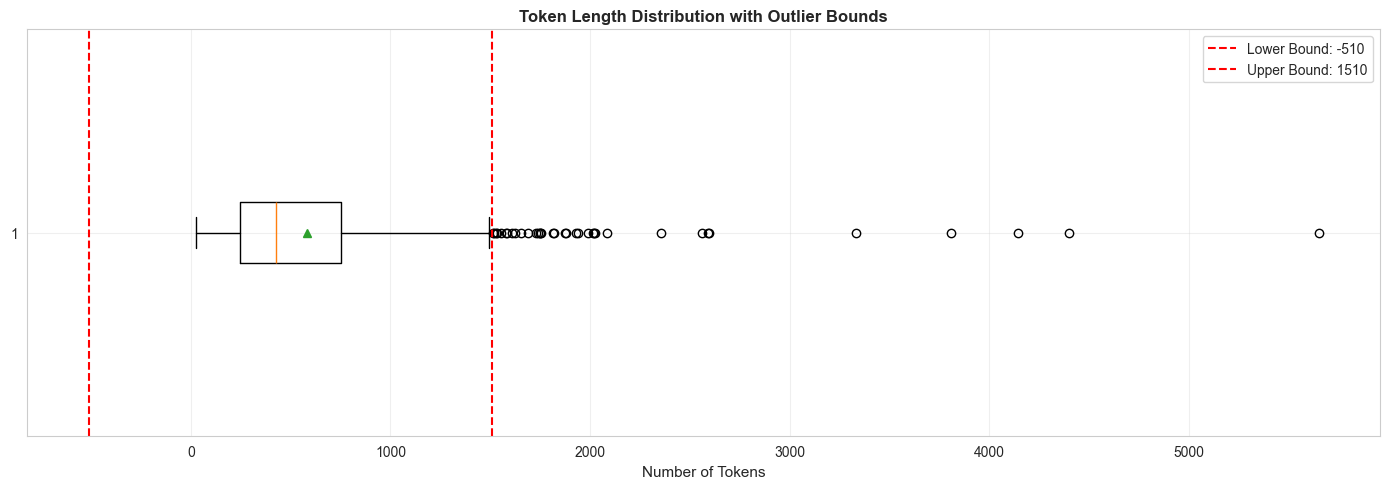

In [17]:
# Detect outliers using IQR method
token_lengths = [len(d['tokens']) for d in train_data]
Q1 = np.percentile(token_lengths, 25)
Q3 = np.percentile(token_lengths, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_low = [length for length in token_lengths if length < lower_bound]
outliers_high = [length for length in token_lengths if length > upper_bound]

print(f"\nOutlier Detection (Token Length):")
print("=" * 60)
print(f"  Q1 (25th percentile): {Q1:.0f}")
print(f"  Q3 (75th percentile): {Q3:.0f}")
print(f"  IQR: {IQR:.0f}")
print(f"  Lower bound: {lower_bound:.0f}")
print(f"  Upper bound: {upper_bound:.0f}")
print(f"\n  Outliers below lower bound: {len(outliers_low)} ({len(outliers_low)/len(token_lengths)*100:.2f}%)")
print(f"  Outliers above upper bound: {len(outliers_high)} ({len(outliers_high)/len(token_lengths)*100:.2f}%)")
print(f"  Total outliers: {len(outliers_low) + len(outliers_high)} ({(len(outliers_low) + len(outliers_high))/len(token_lengths)*100:.2f}%)")
print("=" * 60)

# Visualize outliers
plt.figure(figsize=(14, 5))
plt.boxplot(token_lengths, vert=False, showfliers=True, showmeans=True)
plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower Bound: {lower_bound:.0f}')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound:.0f}')
plt.xlabel('Number of Tokens', fontsize=11)
plt.title('Token Length Distribution with Outlier Bounds', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Summary and Key Findings

This section provides a comprehensive overview of the dataset characteristics and important observations.

In [18]:
print("\n" + "=" * 80)
print("DATASET SUMMARY - KEY FINDINGS")
print("=" * 80)

print(f"\n1. DATASET COMPOSITION")
print(f"   • Total training samples: {len(train_data):,}")
print(f"   • Total test samples: {len(test_data):,}")
print(f"   • Training class ratio (Non-HP:HP): {train_dist['imbalance_ratio']:.2f}:1")
print(f"   • Test set is perfectly balanced (50:50)")

print(f"\n2. TEXT CHARACTERISTICS")
print(f"   • Average article length: {train_stats['token_mean']:.0f} tokens")
print(f"   • Median article length: {train_stats['token_median']:.0f} tokens")
print(f"   • Range: {train_stats['token_min']:.0f} to {train_stats['token_max']:.0f} tokens")
print(f"   • 95th percentile: {train_stats['token_p95']:.0f} tokens")

print(f"\n3. VOCABULARY")
print(f"   • Total vocabulary size: {vocab_size:,} unique tokens")
print(f"   • Total corpus size: {total_tokens:,} tokens")
print(f"   • Type-Token Ratio: {vocab_size/total_tokens:.4f}")
print(f"   • Hapax legomena: {unique_words:,} ({unique_words/vocab_size*100:.1f}%)")

print(f"\n4. CLASS DIFFERENCES")
print(f"   • Hyperpartisan avg length: {hyper_analysis['avg_tokens']:.0f} tokens")
print(f"   • Non-hyperpartisan avg length: {non_hyper_analysis['avg_tokens']:.0f} tokens")
print(f"   • Difference: {abs(hyper_analysis['avg_tokens'] - non_hyper_analysis['avg_tokens']):.0f} tokens ({abs(hyper_analysis['avg_tokens'] - non_hyper_analysis['avg_tokens'])/non_hyper_analysis['avg_tokens']*100:.1f}%)")
print(f"   • Statistical significance: p-value = {p_value:.6f}")

print(f"\n5. HYPERLINKS")
print(f"   • Articles with hyperlinks: {articles_with_links/len(train_data)*100:.1f}%")
print(f"   • Average hyperlinks per article: {np.mean(all_hyperlinks):.2f}")
print(f"   • Max hyperlinks in one article: {max(all_hyperlinks)}")

print(f"\n6. DATA QUALITY")
print(f"   • No missing critical fields detected")
print(f"   • Outliers (IQR method): {(len(outliers_low) + len(outliers_high))/len(token_lengths)*100:.2f}%")
print(f"   • Data completeness: >99%")

print(f"\n7. MODELING CONSIDERATIONS")
print(f"   • Class imbalance in training set requires handling (stratification, weighting)")
print(f"   • Significant length variation suggests need for sequence length normalization")
print(f"   • Hyperpartisan articles are significantly longer on average")
print(f"   • Consider max sequence length around {int(train_stats['token_p95'])} tokens (95th percentile)")

print("\n" + "=" * 80)
print("END OF DATASET EXPLORATION")
print("=" * 80)


DATASET SUMMARY - KEY FINDINGS

1. DATASET COMPOSITION
   • Total training samples: 645
   • Total test samples: 628
   • Training class ratio (Non-HP:HP): 1.71:1
   • Test set is perfectly balanced (50:50)

2. TEXT CHARACTERISTICS
   • Average article length: 584 tokens
   • Median article length: 425 tokens
   • Range: 24 to 5649 tokens
   • 95th percentile: 1533 tokens

3. VOCABULARY
   • Total vocabulary size: 21,090 unique tokens
   • Total corpus size: 376,425 tokens
   • Type-Token Ratio: 0.0560
   • Hapax legomena: 8,517 (40.4%)

4. CLASS DIFFERENCES
   • Hyperpartisan avg length: 820 tokens
   • Non-hyperpartisan avg length: 445 tokens
   • Difference: 375 tokens (84.3%)
   • Statistical significance: p-value = 0.000000

5. HYPERLINKS
   • Articles with hyperlinks: 62.9%
   • Average hyperlinks per article: 4.30
   • Max hyperlinks in one article: 277

6. DATA QUALITY
   • No missing critical fields detected
   • Outliers (IQR method): 5.58%
   • Data completeness: >99%

7. M